In [6]:
!pip install ipykernel

In [7]:
from datetime import datetime, timedelta
# import time
import os
from bs4 import BeautifulSoup
import requests
from xml.etree.ElementTree import XML, fromstring, tostring
import pandas as pd
# %matplotlib inline
from matplotlib import pyplot as plt
# import numpy as np
# import matplotlib.cm as cm

In [8]:
font = {'family': 'serif',
        'color':  'yellow',
        'weight': 'normal',
        'size': 18,
        }


224
224


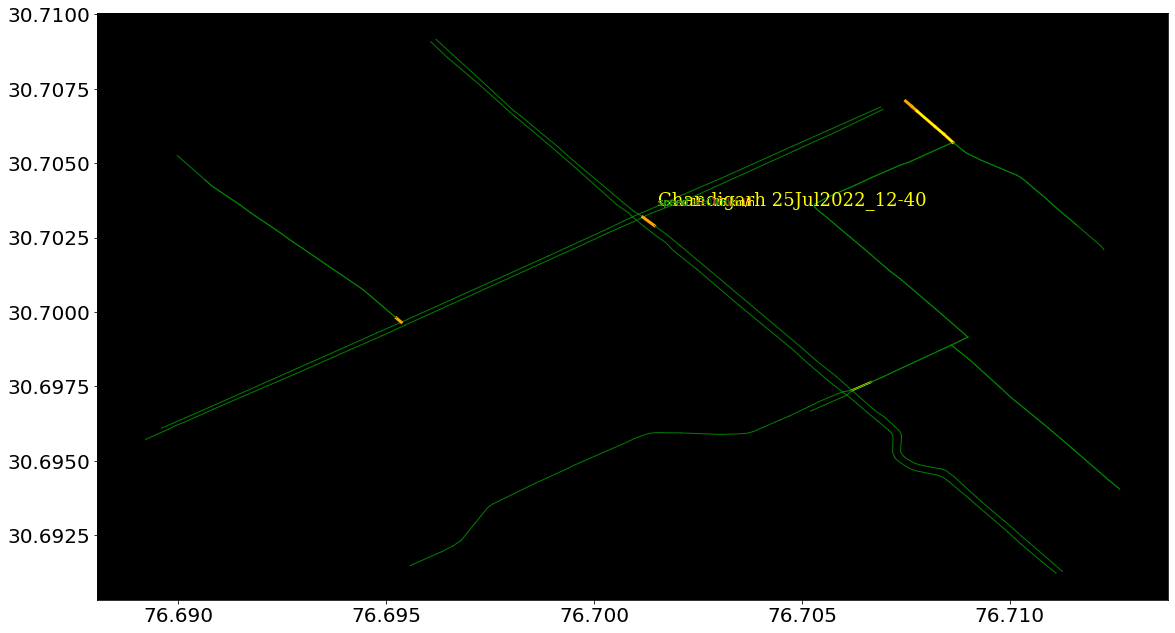

In [9]:
def getTime():
    now = datetime.now()
    current_time = now.strftime("%d%b%Y_%H-%M")
    return current_time
getTime()
my_path = os.path.abspath("C:\ESP32\outputfile")

# Refer to https://developer.here.com/documentation/traffic/dev_guide/topics_v6.1/example-flow.html 
# Common Acronyms: Refer to https://developer.here.com/documentation/traffic/dev_guide/topics/common-acronyms.html 
# Also see: https://stackoverflow.com/a/34150385/1359166
# fi --> flow item [[ tmc, shp, cf ]]
# tmc --> Traffic Message Channel : [[de --> name (de probably language); le --> length of the stretch; pc -->point TMC location code qd --> queuing direction (+/-)]]
# shp: [[fc--> functional classes ]] # https://developer.here.com/documentation/traffic/dev_guide/topics/resource-type-functional-class.html
# cf --> Current flow: [[cn -->confidence number (0-1); ff-->free flow speed; jf --> jam factor (0-10); sp -->avg speed ; su --> avg speed uncut (ignore speed limits, thus should be used); ty -->location reference, free string]]


page = requests.get('https://traffic.ls.hereapi.com/traffic/6.2/flow.xml?apiKey=XRGDIUBOhK1AZqAOT6ct7T6sd7dHW0kkd7xFoJEZyww&bbox=30.70279,76.70063;30.70359,76.70154&responseattributes=sh,fc')
soup = BeautifulSoup(page.text, "lxml")
roads = soup.find_all('fi')
loc_pros=[]
lats=[]
longs=[]
for road in roads:
    myxml = fromstring(str(road))
    fc=5
    for child in myxml:
#         print(child.tag, child.arrrib)
        if 'le' in child.attrib:
            le=float(child.attrib['le'])
        if 'fc' in child.attrib:
            fc=int(child.attrib['fc'])
        if 'cn' in child.attrib:
            cn=float(child.attrib['cn'])
        if 'su' in child.attrib:
            su=float(child.attrib['su'])
        if 'ff' in child.attrib:
            ff=float(child.attrib['ff'])
    if fc <= 4 and cn >=0.7:
        shps = road.find_all('shp')
        for j in range(len(shps)): # going through all the shapes in a FI
            coords = shps[j].text.replace(',',' ').split() #list
            las = []
            lons = []
            for i in range(int(len(coords)/2)): # going through all the lat longs in a shp
                las.append(float(coords[2*i]))
                lons.append(float(coords[2*i+1]))
            loc_pros.append([float(su),float(ff)])
            lats.append(las)
            longs.append(lons)
fig=plt.figure(figsize=(19.20,10.80))
plt.rcParams['axes.facecolor'] = 'black'
plt.grid(False)
print(len(loc_pros))
print(len(lats))
for i in range(len(lats)):
    speed = loc_pros[i][0]
    if speed == 0:
        plt.plot(longs[i],lats[i],c='gray',linewidth=5)
    elif speed < 10:
        plt.plot(longs[i],lats[i],c='brown',linewidth=5)
#         print(str(i)+"\t",longs[i],lats[i],"col based on speed = ",speed)
    elif speed < 15:
        plt.plot(longs[i],lats[i],c='orange',linewidth=3)
    elif speed < 20:
        plt.plot(longs[i],lats[i],c='yellow',linewidth=2)
    else: # more than 20.
        plt.plot(longs[i],lats[i],c='green',linewidth=1)
#plt.xlim(-77.055,-77.015)
#plt.ylim(38.885,38.91)
plt.axis('on')
timeStr=getTime()
saveFileName="speedProfilesChandigarh"+timeStr+".png"
plt.text(76.70154,30.70359, "Chandigarh "+timeStr, fontdict=font)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.text(76.70154,30.70359,"speed <= 10 km/h",color="brown",size=10)
plt.text(76.70154,30.70359,"speed 10 - 15 km/h",color="orange",size=10)
plt.text(76.70154,30.70359,"speed 15 - 20 km/h",color="yellow",size=10)
plt.text(76.70154,30.70359,"speed >20 km/h",color="green",size=10)
plt.savefig(os.path.join(my_path, saveFileName),dpi=900)